In [1]:
import pandas as pd
import requests
import zipfile
import io
import os

# Download the zip file from Google Drive
url = 'https://drive.google.com/uc?export=download&id=16I-dC42IfkCemMtnPfbOkTlxLp14k-Cc'

response = requests.get(url)

# Extract the zip file content directly from the response
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall()

# Load the data from the Excel files in the extracted directory
data_frames = {}
for root, dirs, files in os.walk('.'):
    for file_name in files:
        if file_name.endswith('.xlsx'):
            file_path = os.path.join(root, file_name)
            data_frames[file_name] = pd.read_excel(file_path)

In [2]:
# Columns to normalize
columns_to_normalize = ['illusion 1', 'illusion 2', 'illusion 3', 'illusion 4']

# Normalize the specified columns in each data frame using the method from code 2
for key in data_frames.keys():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        data_frames[key][columns_to_normalize] = (data_frames[key][columns_to_normalize] - 1) / 6

# Group by 'Noise Type', then calculate the mean for each illusion
average_illusions_data = []
for key in data_frames.keys():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        grouped_data = data_frames[key].groupby(['Noise Type']).mean().reset_index()
        average_illusions_data.append(grouped_data)

# Combine all the grouped data frames into one
data_combined = pd.concat(average_illusions_data, ignore_index=True)

In [14]:
data_combined

,Noise Type,illusion 1,illusion 2,illusion 3,illusion 4
0,Other_60fps_1px,0.333333,0.111111,0.305556,0.055556
1,Self_60fps_1px,0.527778,0.472222,0.500000,0.333333
2,Other_60fps_1px,0.388889,0.277778,0.444444,0.250000
3,Self_60fps_1px,0.416667,0.527778,0.444444,0.250000
4,Other_60fps_1px,0.500000,0.444444,0.166667,0.500000
5,Self_60fps_1px,0.555556,0.611111,0.444444,0.444444
6,Other_60fps_1px,0.777778,0.666667,0.722222,0.388889
7,Self_60fps_1px,0.888889,0.722222,0.833333,0.555556
8,Other_60fps_1px,0.333333,0.166667,0.388889,0.277778
9,Self_60fps_1px,0.333333,0.500000,0.500000,0.333333


In [3]:
# Group by 'Noise Type', and calculate mean and standard deviation
grouped = data_combined.groupby(['Noise Type'])
mean_df = grouped.mean().reset_index()
std_dev_df = grouped.std().reset_index()

# Rename columns to indicate that these are means and standard deviations
mean_columns = {
    'illusion 1': 'illusion 1 mean',
    'illusion 2': 'illusion 2 mean',
    'illusion 3': 'illusion 3 mean',
    'illusion 4': 'illusion 4 mean'
}
std_dev_columns = {
    'illusion 1': 'illusion 1 std dev',
    'illusion 2': 'illusion 2 std dev',
    'illusion 3': 'illusion 3 std dev',
    'illusion 4': 'illusion 4 std dev'
}

mean_df.rename(columns=mean_columns, inplace=True)
std_dev_df.rename(columns=std_dev_columns, inplace=True)

# Optionally, you can merge the mean and standard deviation dataframes for a combined view
result_df = pd.merge(mean_df, std_dev_df, on=['Noise Type'])


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load data - assuming 'result_df' is your DataFrame containing the data
data = result_df

# Replace 'px' with 'cs' in the 'Noise Type' column
data['Noise Type'] = data['Noise Type'].replace({
    'Other_60fps_1px': 'Other_60fps_1cs',
    'Self_60fps_1px': 'Self_60fps_1cs'
})

In [5]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15  # You can change the size to fit your needs

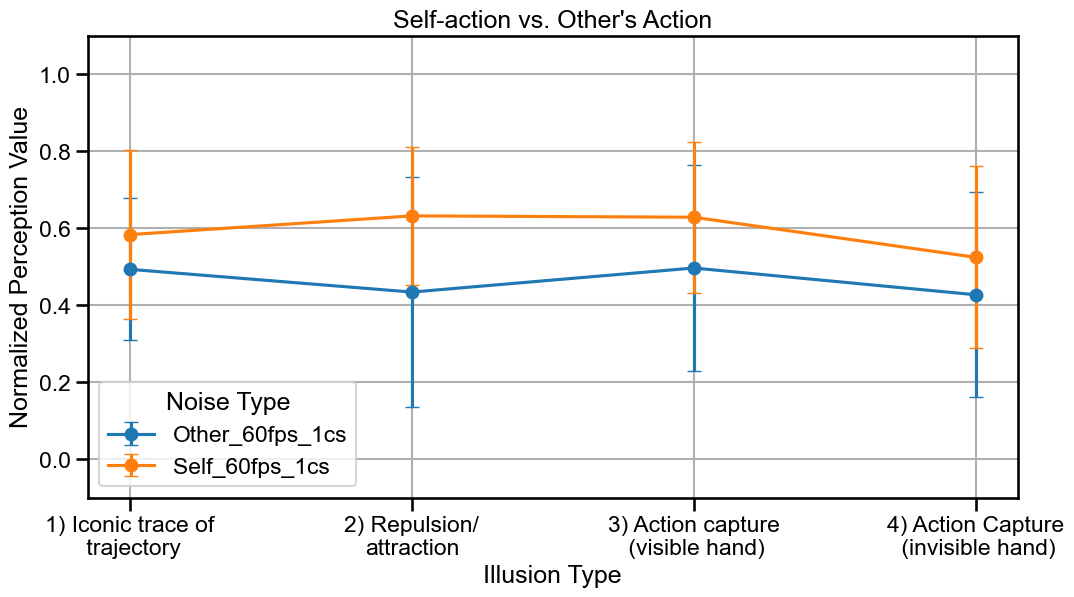

In [31]:
# Define illusions and their respective columns for means and standard deviations
illusions = ['illusion 1', 'illusion 2', 'illusion 3', 'illusion 4']

display_labels = [
    '1) Iconic trace of\n trajectory',
    '2) Repulsion/\nattraction',
    '3) Action capture\n (visible hand)',
    '4) Action Capture\n (invisible hand)'
]

mean_cols = [f'{ill} mean' for ill in illusions]
std_dev_cols = [f'{ill} std dev' for ill in illusions]

# Setting up Seaborn context for larger fonts
sns.set_context("talk")  # Options: paper, notebook, talk, poster (increasing size)

# Prepare the plot
plt.figure(figsize=(12, 6))

# Plot each noise type
for index, row in data.iterrows():
    means = row[mean_cols].values
    std_devs = row[std_dev_cols].values
    plt.errorbar(display_labels, means, yerr=std_devs, label=row['Noise Type'], marker='o', capsize=5)

plt.title("Self-action vs. Other's Action")
plt.xlabel('Illusion Type')
plt.ylabel('Normalized Perception Value')
plt.ylim(-0.1, 1.1)  # Adjust based on the maximum value seen in your dataset
plt.legend(title='Noise Type', loc='lower left', bbox_to_anchor=(0, 0))
plt.grid(True)
plt.savefig('./Self-action_vs_Other.svg', format='svg')
plt.show()


In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Directory containing the files
data_dir = "./Self vs Other"

# Automatically detect all files in the folder matching the naming pattern
file_names = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith("parameter_combinations_") and f.endswith(".xlsx")]

# Load and combine the data
data_list = []
for file in file_names:
    df = pd.read_excel(file)  # Load each Excel file
    data_list.append(df)

# Combine all data into a single DataFrame
data_combined = pd.concat(data_list, ignore_index=True)

In [26]:
# Reshape the DataFrame to long format
data_long = data_combined.melt(
    id_vars=['Noise Type'],  # Columns to keep as is
    value_vars=['illusion 1', 'illusion 2', 'illusion 3', 'illusion 4'],  # Columns to reshape
    var_name='Illusion_Type',  # Name for the new column
    value_name='Rating'  # Name for the values
)

# Standardize column names (remove spaces and ensure consistent formatting)
data_long.columns = data_long.columns.str.strip().str.replace(' ', '_').str.title()

# Print reshaped data to verify
print("Reshaped Data:")
print(data_long.head())

# Perform Two-Way ANOVA
model = ols('Rating ~ C(Illusion_Type) * C(Noise_Type)', data=data_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print("\nTwo-Way ANOVA Results:")
print(anova_table)


Reshaped Data:
        Noise_Type Illusion_Type  Rating
0  Other_60fps_1px    illusion 1     3.0
1   Self_60fps_1px    illusion 1     4.0
2  Other_60fps_1px    illusion 1     3.0
3   Self_60fps_1px    illusion 1     4.5
4  Other_60fps_1px    illusion 1     3.0

Two-Way ANOVA Results:
                                    sum_sq     df          F    PR(>F)
C(Illusion_Type)                  7.003906    3.0   1.092974  0.353411
C(Noise_Type)                    28.907552    1.0  13.533249  0.000308
C(Illusion_Type):C(Noise_Type)    3.139323    3.0   0.489898  0.689717
Residual                        393.031250  184.0        NaN       NaN
